### Spoken Language Processing
В этом задании предлагается обучить классификатор возраста по голосу (пример с тем, как это можно сделать для пола см. в семинаре)

Подумайте, как лучше предсказывать возраст (может быть разбить на группы?) и какой лосс использовать

P.S. не забудьте, что если вы работаете в Colab, то вы можете поменять среду выполнения на GPU/TPU!

Вопросы по заданию/материалам: @Nestyme

In [1]:
!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148

In [2]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'

## Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см семинар)
2. Соберите пары "голос"  — "класс возраста" также, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мелспектрограммы при помощи `torchaudio либо` `librosa`

P.S. вы можете использовать свою реализацию, а можете предложенную (см следующие ячейки)

In [3]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm
import torch as t


class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm(people):
            try:
                target = self.return_age(person.name)
                for i in range(len(person.sentences)):
                    spectrograms_and_targets.append(
                        self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
            except:
                print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age <=25:
            return 0
        if 25 < age <= 40:
            return 1
        if  age > 40:
            return 2

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)


class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

    @staticmethod
    def padd_sequences(lines, pad_token=0):
        lengths = [len(line) for line in lines]
        max_length = max(lengths)

        return np.array(
            [
                line + [pad_token] * (max_length - lengths[i])
                for i, line in enumerate(lines)
            ]
        )

Простая сверточная сеть, ее можно дотюнить или поменять по желанию

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])
        self.bn = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * len(window_sizes), 3)
        self.drop = nn.Dropout(p=0.15)
        
    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]
        x = self.bn(x)
        x = self.drop(x)
        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits) #.view(-1)
        return probs

In [5]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.64it/s]


# Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device} mode')
patience = 500
best_loss = 1000
cnt = 0

using cuda mode


In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.synchronize()

C:\Users\BIT\.conda\envs\deep\lib\site-packages\torch\cuda\memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [8]:
model = Model()
if device == torch.device('cuda'):
    model.cuda()
else:
    model.cpu()
model.train()

Model(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=[3, 128], stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=[4, 128], stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=[5, 128], stride=(1, 1), padding=(4, 0))
  )
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=384, out_features=3, bias=True)
  (drop): Dropout(p=0.15, inplace=False)
)

In [9]:
BATCH_SIZE = 64

optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), lr=0.005 , eps=1e-5
)

def model_loss(probs, targets):
        return nn.CrossEntropyLoss(weight=1-torch.Tensor([0.24,0.63,0.13]).cuda())(probs, targets)
        #return nn.CrossEntropyLoss()(probs, targets)

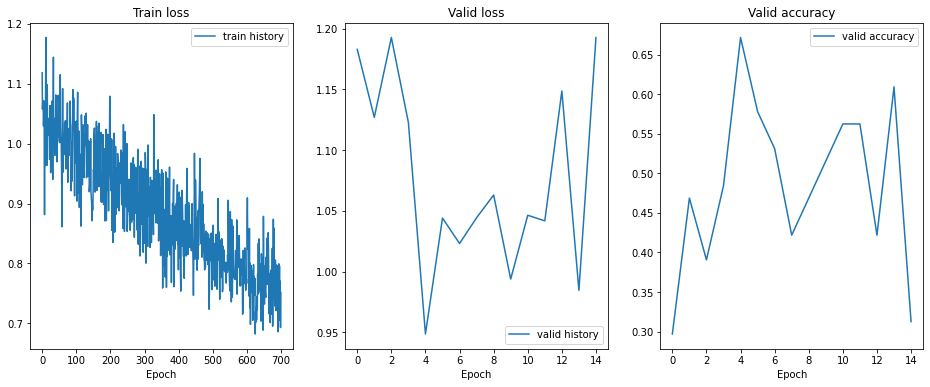

training finished


In [10]:
from IPython.display import clear_output
import math

min_loss = np.inf
min_acc = np.inf

train_loss = []
train_history = []
train_acc = []
valid_acc = []
valid_history = []

model.train()

for i in range(1500):

    optimizer.zero_grad()

    input, target = trainset.next_batch(BATCH_SIZE, device=device)
    out = model(input)
    loss = model_loss(out, target.long())
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        model.eval()

        with torch.no_grad():
            optimizer.zero_grad()

            input, target = validset.next_batch(BATCH_SIZE, device=device)
            out = model(input)
            valid_loss = model_loss(out, target.long())
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            out = np.argmax(out,axis=1)
            val_acc = accuracy_score(target,out)
            valid_acc.append(val_acc)
            valid_history.append(valid_loss.item())
            print(f'accuracy_score:{val_acc}')
            print("i {}, valid {}".format(i, valid_loss.item()))
            print("_________")
    
        model.train()

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
        clear_output(True)
        if train_history is not None:
            ax[0].plot(train_history, label='train history')
            ax[0].set_xlabel('Epoch')
            ax[0].set_title('Train loss')
            ax[0].legend()
        if valid_history is not None:
            ax[1].plot(valid_history, label='valid history')
            ax[1].legend()
            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Valid loss')
        if valid_acc is not None:
            ax[2].plot(valid_acc, label='valid accuracy')
            ax[2].legend()
            ax[2].set_xlabel('Epoch')
            ax[2].set_title('Valid accuracy')
        plt.legend()
        plt.show()
    train_history.append(loss.item())

    if i % 50 == 0 and best_loss > valid_loss.item():
        best_loss = valid_loss.item()
        cnt = 0
    else:
        cnt += 1

    if cnt > patience:
        break
print('training finished')

In [11]:
model.eval()
for i in range(30):

    with torch.no_grad():
        optimizer.zero_grad()

        input, target = testset.next_batch(BATCH_SIZE, device=device)
        out = model(input)
        test_loss = model_loss(out, target.long())
        out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
        out = np.argmax(out,axis=1)
        print(f'accuracy_score:{accuracy_score(out, target)}')
        print("_________")
print('testing finished')

accuracy_score:0.515625
_________
accuracy_score:0.34375
_________
accuracy_score:0.4375
_________
accuracy_score:0.515625
_________
accuracy_score:0.296875
_________
accuracy_score:0.34375
_________
accuracy_score:0.5
_________
accuracy_score:0.4375
_________
accuracy_score:0.375
_________
accuracy_score:0.40625
_________
accuracy_score:0.5
_________
accuracy_score:0.59375
_________
accuracy_score:0.46875
_________
accuracy_score:0.3125
_________
accuracy_score:0.40625
_________
accuracy_score:0.40625
_________
accuracy_score:0.40625
_________
accuracy_score:0.359375
_________
accuracy_score:0.421875
_________
accuracy_score:0.453125
_________
accuracy_score:0.453125
_________
accuracy_score:0.4375
_________
accuracy_score:0.484375
_________
accuracy_score:0.453125
_________
accuracy_score:0.578125
_________
accuracy_score:0.484375
_________
accuracy_score:0.46875
_________
accuracy_score:0.34375
_________
accuracy_score:0.515625
_________
accuracy_score:0.5
_________
testing finished

# Выводы:

1) Постарался обучить свой классификатор возраста по голосу, разделив людей на группы (до 25, от 25 до 40, после 40).

2) Усложнил семинарскую сеть со свёртками с различными kernel_size (3,4,5) и оптимизатором Adam с lr=0.005, добавив BatchNorm, Dropout c p=0.15 и линейный слой в конец модели для классификации на 3 класса; взял CE loss с применением весов (0.24,0.63,0.13), из-за выхода модели в 3 класса и уменьшения негативного влияния дисбаланса классов. Количество итераций взял 1500 с предварительным выходом и batch_size = 64. Результат получился немного лучше константного предсказания, по большей части, как мне кажется, из-за примитивности предобработки и слабой модели (касательно использования различных идей). Также пытался двигать границы для уменьшения дисбаланса, но из-за малых различий в голосах модель не могла обучиться; пытался использовать Factorized-TDNN, добавив линейный слой в конец, но сеть плохо обучалась.

3) Добавление BatchNorm'а оказался самым эффективным подходом, то есть результат сильно улучшился и проблем с переобучением на самый распространённый класс стало меньшe, из-за того что линейная модель (линейный слой) лучше работает с нормированными данными; также возможно неплохое улучшение результата могут дать новые данные и последующий подбор границ с наиболее различающимися голосами.

4) В голосовом помощнике, например, чтобы модель понимала пользуется ли ей ребёнок, молодой человек или старик, с помощью данной информации можно отфильтровывать ответы, которые обычно являются неподходящими для данной категории, и таким образом делать более хорошие рекомендации. Также с помощью данного классификатора какая-либо компания, могла бы используя голос человека, пока он разговаривает с автоматом, определить какие её продукты могли бы быть ему предположительно нужны, после чего сообщать данную информацию оператору (например, компания-маркетплейс).